In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [40]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [41]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [42]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
test = session.query(Measurement).first()
test.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f00909b010>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [46]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date = str(most_recent_date)
most_recent_date

"('2017-08-23',)"

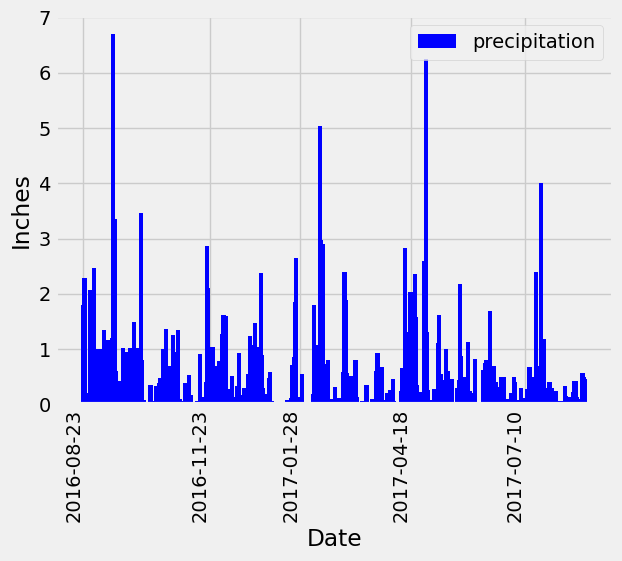

In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date = str(most_recent_date)
most_recent_as_dt = datetime.strptime(most_recent_date, "('%Y-%m-%d',)").date()

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_as_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
data_df = pd.DataFrame(data)
data_df = data_df.rename(columns={"date": "Date", "prcp": "Precipitation (in)"})


# Sort the dataframe by date
sorted_data_df = data_df.sort_values(by=["Date"], ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = sorted_data_df["Date"]
y_axis = sorted_data_df["Precipitation (in)"]
plt.bar(x_axis, y_axis, color='blue', width=3)
show_xticks = ['2016-08-23', '2016-11-23', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(show_xticks, rotation='vertical', ha='right')

plt.ylabel("Inches")
plt.xlabel("Date")

plt.legend(['precipitation'])

plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_data_df.describe()

,Precipitation (in)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [49]:
print(sorted_data_df)

            Date  Precipitation (in)
0     2016-08-23                0.00
1009  2016-08-23                 NaN
1529  2016-08-23                1.79
704   2016-08-23                0.05
361   2016-08-23                0.15
...          ...                 ...
1527  2017-08-22                0.00
1008  2017-08-23                0.00
360   2017-08-23                0.00
1528  2017-08-23                0.08
2229  2017-08-23                0.45

[2230 rows x 2 columns]


In [50]:
data_dict = sorted_data_df.to_dict('split')['data']

# Exploratory Station Analysis

In [51]:
test2 = session.query(Measurement).first()
test2.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1f00909b010>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [52]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Measurement.station).distinct().count()
station_count

9

In [53]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = (
session.query(Measurement.station, func.count(Measurement.id))
.group_by(Measurement.station)
.order_by(func.count(Measurement.id).desc())
)

for station_name, count in query:
    print(station_name, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [54]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = 'USC00519281'

sel = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]

station_temps = session.query(*sel).filter((Measurement.station) == most_active_station).all()
station_temps



[(54.0, 85.0, 71.66378066378067)]

In [55]:
most_active_station = 'USC00519281'

station_most_recent_date = session.query(func.max(Measurement.date)).filter(Measurement.station == most_active_station).first()

station_most_recent_date = str(station_most_recent_date)

station_most_recent_as_dt = datetime.strptime(station_most_recent_date, "('%Y-%m-%d',)").date()

#station_most_recent_as_dt

station_one_year_ago = station_most_recent_as_dt - dt.timedelta(days=365)

station_one_year_ago

datetime.date(2016, 8, 18)

In [56]:
station_most_recent_as_dt

datetime.date(2017, 8, 18)

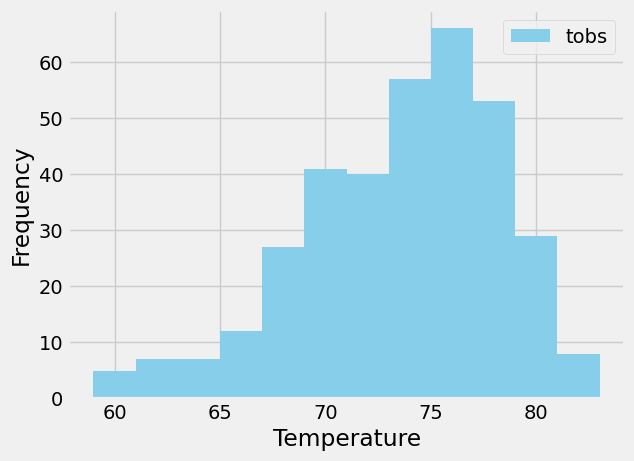

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station = 'USC00519281'

temp_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

temperatures = pd.DataFrame(temp_data, columns=['tobs'])

temperatures.plot.hist(bins=12, color='skyblue')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


# Close Session

In [63]:
station_list = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
station_list

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [59]:
# Close Session
session.close()